In [102]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import xgboost

In [103]:
#Load the data
caci_data_filepath = 'C:/Users/joewe/Desktop/Bill_defaults.csv'
bill_defaults = pd.read_csv(caci_data_filepath)
bill_default = pd.DataFrame(bill_defaults)

In [104]:
print(bill_default.columns)

Index(['uid', 'late_default', 'cli_anc', 'cli_ageband', 'cli_payment',
       'oc_inc0010', 'oc_inc50pl', 'oc_children3pl', 'oc_children0004',
       'oc_children0510', 'oc_retired', 'oc_selfemp', 'oc_student', 'oc_unemp',
       'oc_socrent', 'oc_privrent', 'oc_overdraft', 'oc_savs10pl',
       'oc_cards2pl'],
      dtype='object')


## Data Preprocessing

In [105]:
#Check if dataset is balanced
bill_default.late_default.value_counts()

0    16255
1     3745
Name: late_default, dtype: int64

In [106]:
#As dataset is not balanced, we have to look at other approaches as we are not able to resample or drop data.

In [107]:
#Convert 'cli_payment' from string to int 
bill_default["cli_payment"] = LabelEncoder().fit_transform(bill_default["cli_payment"])

In [108]:
bill_default

,uid,late_default,cli_anc,cli_ageband,cli_payment,oc_inc0010,oc_inc50pl,oc_children3pl,oc_children0004,oc_children0510,oc_retired,oc_selfemp,oc_student,oc_unemp,oc_socrent,oc_privrent,oc_overdraft,oc_savs10pl,oc_cards2pl
0,1,1,3300,2,2,0.030355,0.475623,0.021374,0.165254,0.132862,0.000031,0.150273,0.042310,0.025378,0.012832,0.793294,0.172783,0.179815,0.306499
1,2,0,3010,4,1,0.313327,0.060590,0.027987,0.024381,0.066548,0.001478,0.118803,0.007655,0.075782,0.750370,0.069109,0.114262,0.036342,0.075723
2,3,0,2780,6,1,0.063608,0.161459,0.001920,0.003073,0.005036,0.817904,0.021434,0.002262,0.000317,0.026640,0.021453,0.056320,0.304369,0.195838
3,4,0,4400,3,1,0.013214,0.469807,0.195210,0.169214,0.413697,0.000132,0.101393,0.023778,0.029276,0.022806,0.120235,0.184631,0.147863,0.286992
4,5,0,4540,4,1,0.007277,0.527970,0.180975,0.218566,0.414872,0.001453,0.119810,0.002274,0.031067,0.001271,0.082093,0.181568,0.203448,0.244626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,0,1760,3,0,0.025060,0.272871,0.151226,0.178796,0.340125,0.000153,0.091035,0.011942,0.020050,0.030269,0.336744,0.197441,0.070698,0.230265
19996,19997,0,4680,2,1,0.095052,0.165273,0.119355,0.295110,0.305598,0.000034,0.079453,0.043436,0.017367,0.213339,0.269374,0.136288,0.031117,0.055918
19997,19998,0,1830,1,2,0.123681,0.213847,0.023502,0.141719,0.069495,0.000054,0.036993,0.334451,0.029190,0.023805,0.325189,0.100020,0.024196,0.021911
19998,19999,1,2890,3,2,0.022261,0.383774,0.165557,0.188649,0.364926,0.000116,0.128175,0.018341,0.012351,0.053193,0.099822,0.241522,0.076225,0.196060


## Feature Selection


In [109]:
#Test for significance 
bill_default.corr(method = 'spearman')

,uid,late_default,cli_anc,cli_ageband,cli_payment,oc_inc0010,oc_inc50pl,oc_children3pl,oc_children0004,oc_children0510,oc_retired,oc_selfemp,oc_student,oc_unemp,oc_socrent,oc_privrent,oc_overdraft,oc_savs10pl,oc_cards2pl
uid,1.000000,-0.006540,0.002598,0.003965,-0.000291,0.000111,-0.002361,-0.004660,-0.006772,-0.006473,0.003270,0.001346,-0.009942,0.001681,0.004469,-0.007510,0.007491,-0.000684,0.001845
late_default,-0.006540,1.000000,-0.016232,-0.268465,0.022640,0.036737,-0.007600,0.231101,0.261660,0.247169,-0.275727,0.081333,0.180143,0.194977,0.133106,0.202975,0.131613,-0.266887,-0.133779
cli_anc,0.002598,-0.016232,1.000000,0.000722,0.005517,-0.009193,0.010020,0.003246,0.001856,0.003432,0.001643,0.004795,0.001729,-0.004229,-0.001889,-0.005148,0.005882,0.003742,0.007049
cli_ageband,0.003965,-0.268465,0.000722,1.000000,-0.005847,0.188640,-0.266833,-0.638573,-0.866863,-0.748927,0.937903,-0.212646,-0.741839,-0.497462,-0.098738,-0.651641,-0.594561,0.707254,0.274339
cli_payment,-0.000291,0.022640,0.005517,-0.005847,1.000000,0.001945,0.000726,0.003635,0.003594,0.001359,-0.002082,-0.002148,-0.000920,0.010504,-0.000151,-0.009447,-0.004151,-0.006418,-0.006440
oc_inc0010,0.000111,0.036737,-0.009193,0.188640,0.001945,1.000000,-0.903873,-0.336331,-0.294920,-0.357130,0.147938,-0.471236,-0.096723,0.130529,0.587056,-0.076119,-0.578558,-0.357776,-0.734648
oc_inc50pl,-0.002361,-0.007600,0.010020,-0.266833,0.000726,-0.903873,1.000000,0.307251,0.292607,0.326480,-0.211655,0.551558,0.183136,0.004963,-0.509880,0.158486,0.560868,0.299037,0.671262
oc_children3pl,-0.004660,0.231101,0.003246,-0.638573,0.003635,-0.336331,0.307251,1.000000,0.841062,0.951905,-0.687028,0.423215,0.310936,0.403934,0.092955,0.352828,0.591035,-0.580710,-0.076698
oc_children0004,-0.006772,0.261660,0.001856,-0.866863,0.003594,-0.294920,0.292607,0.841062,1.000000,0.940409,-0.882469,0.269655,0.608560,0.390688,0.032612,0.599675,0.640232,-0.670688,-0.183178
oc_children0510,-0.006473,0.247169,0.003432,-0.748927,0.001359,-0.357130,0.326480,0.951905,0.940409,1.000000,-0.799101,0.373316,0.453454,0.371170,0.049024,0.476137,0.654117,-0.615874,-0.087411


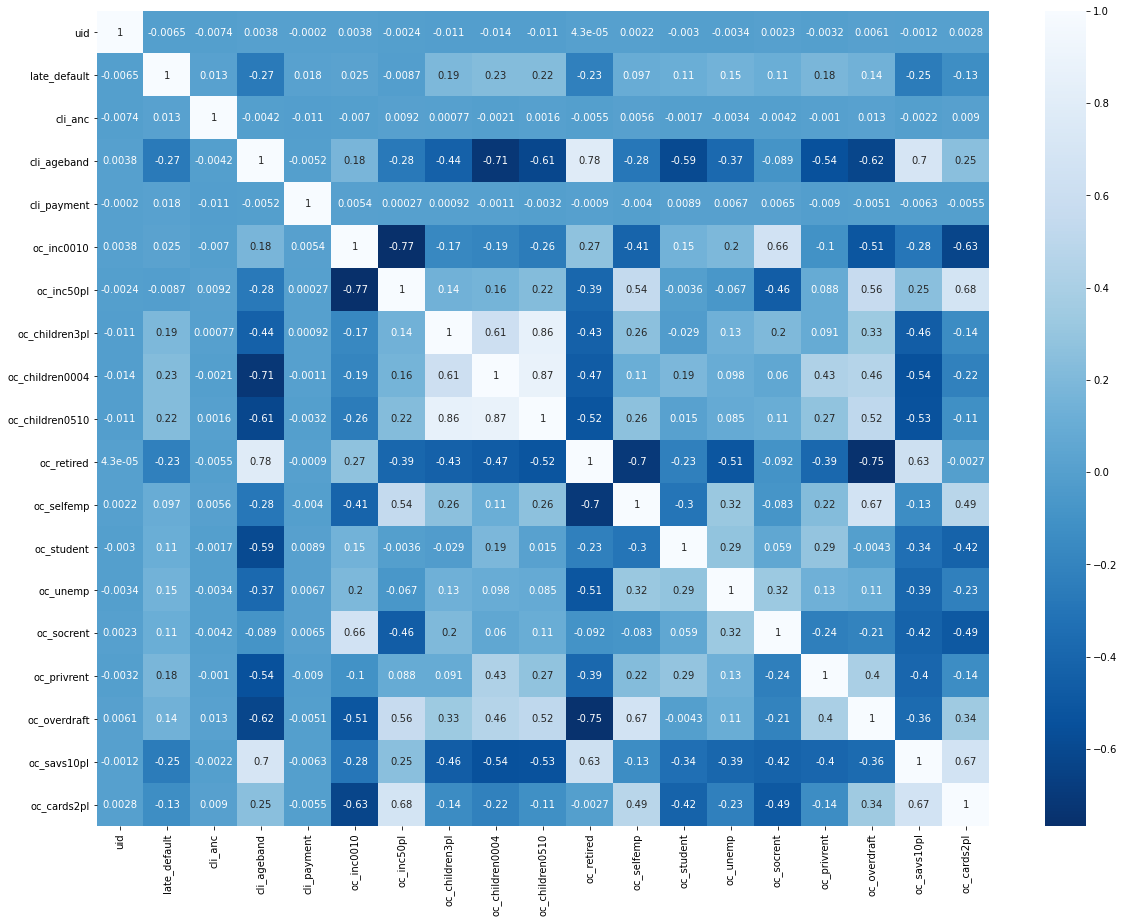

In [110]:
plt.figure(figsize=(20,15))
cor = bill_default.corr()
sns.heatmap(cor, annot = True, cmap=plt.cm.Blues_r)
plt.show()

In [111]:
#Create a function to drop correlated variables by setting a threshold (arbitary) good idea to test with multiple levels of threshold
# I set 0.7 using visual 
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold: #Leave abs, so negative correlation is also inc
                colname = corr_matrix.columns[i] #Store ones above threshold (only i so no duplicates)
                col_corr.add(colname)
    return col_corr

In [112]:
corr_features = correlation(bill_default, 0.7)
print ('Features to drop =', corr_features)

Features to drop = {'oc_children0004', 'oc_overdraft', 'oc_inc50pl', 'oc_retired', 'oc_children0510'}


In [113]:
#Drop highly correlated features
new_df = bill_default.drop(['uid','oc_children0004', 'oc_children0510', 'oc_inc50pl','oc_overdraft','oc_retired'], axis=1)


In [114]:
#Print the new features
print(new_df.columns)

Index(['late_default', 'cli_anc', 'cli_ageband', 'cli_payment', 'oc_inc0010',
       'oc_children3pl', 'oc_selfemp', 'oc_student', 'oc_unemp', 'oc_socrent',
       'oc_privrent', 'oc_savs10pl', 'oc_cards2pl'],
      dtype='object')


In [115]:
#Setting dependent variable as late default
y = new_df.late_default

In [116]:
#Create list of features for independent variables
feature_names = ['cli_anc', 'cli_ageband', 'cli_payment', 'oc_inc0010',
       'oc_children3pl', 'oc_selfemp', 'oc_student', 'oc_unemp', 'oc_socrent',
       'oc_privrent', 'oc_savs10pl', 'oc_cards2pl']

X = new_df[feature_names]

print(X)
X.shape

       cli_anc  cli_ageband  cli_payment  oc_inc0010  oc_children3pl  \
0         3300            2            2    0.030355        0.021374   
1         3010            4            1    0.313327        0.027987   
2         2780            6            1    0.063608        0.001920   
3         4400            3            1    0.013214        0.195210   
4         4540            4            1    0.007277        0.180975   
...        ...          ...          ...         ...             ...   
19995     1760            3            0    0.025060        0.151226   
19996     4680            2            1    0.095052        0.119355   
19997     1830            1            2    0.123681        0.023502   
19998     2890            3            2    0.022261        0.165557   
19999     4340            3            2    0.044949        0.066532   

       oc_selfemp  oc_student  oc_unemp  oc_socrent  oc_privrent  oc_savs10pl  \
0        0.150273    0.042310  0.025378    0.012832   

(20000, 12)

# Normalize the data

As the features data hold different types of data (unbounded, 0-1 and categorical), we want to transform the data such that its distribution will have a mean value 0 and standard deviation of 1. The idea is to normalize the features of X before applying any ML model. This is to improve weighted distribution.

In [117]:
#Scaling the data to normalize using Standard Scaler
scaler = StandardScaler().fit(X)
scaled_X = scaler.transform(X)

# Cross Validation

We want to split the data into two categories, one for testing and one for training. This will help us overcome any issues with over-fitting

In [118]:
#Split data 
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, random_state = 8, test_size = 0.3)

In [119]:
X_train.shape

(14000, 12)

## Using Logistic Regression

In [120]:
from sklearn.linear_model import LogisticRegression

In [121]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_LR = log_reg.predict(X_test)

# Evaluation

In [122]:
#Using metric score to determine accuracy
metrics.accuracy_score(y_test, y_pred_LR)

0.8156666666666667

## Confusion Matrix

In [123]:
print('TN, FP, FN, TP  = ', metrics.confusion_matrix(y_test, y_pred_LR).ravel())

TN, FP, FN, TP  =  [4891   13 1093    3]


## Using KNN Classifier 

In [124]:
#Use CV with KNN model
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
cv_y_pred = knn.predict(X_test)
metrics.accuracy_score(y_test, cv_y_pred)

0.8241666666666667

In [101]:
#Loop CV func to obtain best value of k
k_scores =[]
for k in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, scaled_X, y, cv=10, scoring = 'accuracy')
    k_scores.append(scores.mean())

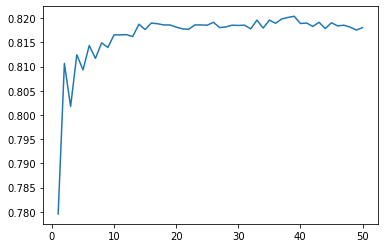

In [125]:
plt.plot(range(1,51), k_scores)

In [126]:
#Use metric score to determine accuracy of model after applying CV
scores= cross_val_score(knn, scaled_X, y, cv = 10, scoring = 'accuracy')
print('CV Score for KNN =', scores)
print('Score mean for KNN =', np.mean(scores))

CV Score for KNN = [0.8215 0.8215 0.817  0.8305 0.814  0.8155 0.808  0.8105 0.8225 0.8205]
Score mean for KNN = 0.8181499999999999


## Confusion Matrix

In [127]:
print('TN, FP, FN, TP  = ', metrics.confusion_matrix(y_test, cv_y_pred).ravel())
#The FN rate is very high mainly due to the unbalanced data as we have significantly more people with no missed payments, hence it tends to incorrectly indicate that the individual is able to make payments when they cant

TN, FP, FN, TP  =  [4709  195  860  236]


## XGBoost Boosted Forest

In [128]:
from xgboost import XGBRFClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
#Define the model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred_BF = model.predict(X_test)
predictions = [round(value) for value in y_pred_BF]
# evaluate predictions
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.48%


## Confusion Matrix

In [129]:
print('TN, FP, FN, TP  = ', metrics.confusion_matrix(y_test, y_pred_BF).ravel())

TN, FP, FN, TP  =  [4593  311  740  356]


# Evaluation

## ROC AUC 

In [130]:
from sklearn.metrics import roc_curve, auc


In [131]:
#We determine the False postive rate and the True Postive rate and we plot it to compare which ML model is best suited
#Logistic Reg
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_LR)
auc_LR = auc(logistic_fpr, logistic_tpr)
#KNN
knn_fpr, knn_tpr, threshold = roc_curve(y_test, cv_y_pred)
auc_knn = auc(knn_fpr, knn_tpr)
#Boosted Forest
BF_fpr, BF_tpr, threshold = roc_curve(y_test, y_pred_BF)
auc_BF = auc(BF_fpr, BF_tpr)





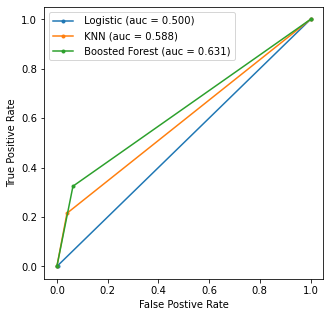

In [132]:
plt.figure(figsize=(5,5))
plt.plot(logistic_fpr, logistic_tpr, marker ='.', label = ' Logistic (auc = %0.3f)' % auc_LR)
plt.plot(knn_fpr, knn_tpr, marker ='.', label = ' KNN (auc = %0.3f)' % auc_knn)
plt.plot(BF_fpr, BF_tpr, marker ='.', label = ' Boosted Forest (auc = %0.3f)' % auc_BF)
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



## F1 Score

In [133]:
from sklearn.metrics import f1_score

In [134]:
f1_LR = f1_score(y_test, y_pred_LR)
f1_KNN = f1_score(y_test, cv_y_pred)
f1_BF = f1_score(y_test, y_pred_BF)

print('F1 SCore for Logistic Regression =', f1_LR)
print('F1 Score for KNN =', f1_KNN)
print('F1 Score for Gradient Boosted Forest =', f1_BF)

F1 SCore for Logistic Regression = 0.00539568345323741
F1 Score for KNN = 0.3091028159790439
F1 Score for Gradient Boosted Forest = 0.4038570618264322


Here we can see that Gradient Boosted Forest classifier has the highest F1 score, where the metric is as follows:

F1 score = 2 * (Precision * Recall) / (Precision + Recall)

Where,

Precision  = True Positives / (True Positives/ False Positives)

Recall = True positives / (True Positives + False Negatives)

Making the Boosted Forest a better baseline model


# SMOTE 

## Synthetic Minority Oversampling Technique
A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.

In [135]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [136]:
#We use the counter object to summarize the number of examples in each class to confirm the dataset was transformed correctly.
#Original Count of y
counter = Counter(y)
print(counter)

Counter({0: 16255, 1: 3745})


In [137]:
oversample = SMOTE()
smote_scaled_X, smote_y = oversample.fit_resample(scaled_X, y)

In [138]:
#Count of y after SMOTE
counter = Counter(smote_y)
print(counter)

Counter({1: 16255, 0: 16255})


In [139]:
#Here we compare the Boosted Forest and KNN model after using SMOTE to see if there is any improvement
#Split data 
smote_X_train, smote_X_test, smote_y_train, smote_y_test = train_test_split(smote_scaled_X, smote_y, random_state = 8, test_size = 0.2)
#With KNN model
knn.fit(smote_X_train, smote_y_train)
smote_y_pred_knn = knn.predict(smote_X_test)
#With BF Model
model.fit(smote_X_train, smote_y_train)
smote_y_pred_BF = model.predict(smote_X_test)


# Evaluation

In [140]:
#Use metric score to determine accuracy for KNN and BF
print('KNN Metric score before SMOTE =', metrics.accuracy_score(y_test, cv_y_pred))
print('KNN Metric score after SMOTE =', metrics.accuracy_score(smote_y_test, smote_y_pred))


print('BF Metric score before SMOTE =', metrics.accuracy_score(y_test, y_pred_BF))
print('BF Metric score after SMOTE =', metrics.accuracy_score(smote_y_test, smote_y_pred_BF))





KNN Metric score before SMOTE = 0.8241666666666667
KNN Metric score after SMOTE = 0.7923715779760074
BF Metric score before SMOTE = 0.8248333333333333
BF Metric score after SMOTE = 0.8418948015995078


In [141]:
#Here using SMOTE we can see that the number of False Positives and False Negatives have drastically reduced, with very little impact to the accuracy score of the model.
# This is at the expense of increased FP as SMOTE bootstraps the number of default payees.
print('TN, FP, FN, TP  = ', metrics.confusion_matrix(smote_y_test, smote_y_pred).ravel())

TN, FP, FN, TP  =  [2273  928  422 2879]


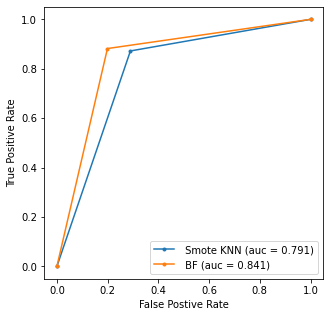

In [142]:
#Now we compare the ROC AUC score after using SMOTE
#KNN
smote_knn_fpr, smote_knn_tpr, threshold = roc_curve(smote_y_test, smote_y_pred)
smote_auc_knn = auc(smote_knn_fpr, smote_knn_tpr)
#Boosted Forest
smote_BF_fpr, smote_BF_tpr, threshold = roc_curve(smote_y_test, smote_y_pred_BF)
smote_auc_BF = auc(smote_BF_fpr, smote_BF_tpr)



plt.figure(figsize=(5,5))
plt.plot(smote_knn_fpr, smote_knn_tpr, marker ='.', label = ' Smote KNN (auc = %0.3f)' % smote_auc_knn)
plt.plot(smote_BF_fpr, smote_BF_tpr, marker ='.', label = ' BF (auc = %0.3f)' % smote_auc_BF)
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## F1 score

In [143]:
smote_f1_KNN = f1_score(smote_y_test, smote_y_pred)
smote_f1_BF = f1_score(smote_y_test, smote_y_pred_BF)

print('F1 SCore for KNN without SMOTE =', f1_KNN)
print('F1 Score for KNN with SMOTE =', smote_f1_KNN)

print('F1 SCore for BF without SMOTE =', f1_BF)
print('F1 SCore for BF with SMOTE =', smote_f1_BF)

F1 SCore for KNN without SMOTE = 0.3091028159790439
F1 Score for KNN with SMOTE = 0.8100731570061902
F1 SCore for BF without SMOTE = 0.4038570618264322
F1 SCore for BF with SMOTE = 0.8499270072992701
